In [ ]:
#MODEL WITH DEBIASING (w=0.5; c=0.5)

In [3]:

#w=0.5, c=0.5
import torch
from transformers import BertTokenizer, BertForMaskedLM
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from tqdm import tqdm
import torch.nn.functional as F
from contextlib import contextmanager
import os
import copy

#load and normalize warmth/competence vectors
warmth_vector = pd.read_csv('/Users/aleksandragarbat/Desktop/Thesis/warmth_direction.csv').values.flatten()
competence_vector = pd.read_csv('/Users/aleksandragarbat/Desktop/Thesis/competence_direction.csv').values.flatten()

warmth_vector = torch.tensor(warmth_vector, dtype=torch.float32)
competence_vector = torch.tensor(competence_vector, dtype=torch.float32)

warmth_vector = warmth_vector / warmth_vector.norm()
competence_vector = competence_vector / competence_vector.norm()

def gram_schmidt(vectors):
    ortho = []
    for v in vectors:
        for u in ortho:
            v = v - torch.dot(v, u) * u
        v = v / torch.norm(v)
        ortho.append(v)
    return ortho

g0, g1 = gram_schmidt([warmth_vector, competence_vector])
components = [g0, g1]
weights = [0.5, 0.5]

def debias_custom(h, components, weights, n_mask=None):
    debiased = h.clone()
    for i, g in enumerate(components):
        weight = weights[i]
        n = n_mask[i] if n_mask is not None else 1
        debiased -= weight * n * torch.dot(h, g) * g
    return debiased

class MLM_Dataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128, mask_prob=0.15):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.mask_prob = mask_prob
        self.mask_token_id = tokenizer.mask_token_id

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].flatten()
        attention_mask = encoding["attention_mask"].flatten()

        labels = input_ids.clone()

        #identify manually placed [MASK] tokens
        manual_mask_positions = (input_ids == self.mask_token_id)

        #create random mask with probability
        rand = torch.rand(input_ids.shape)
        special_tokens = torch.tensor([
            self.tokenizer.cls_token_id,
            self.tokenizer.sep_token_id,
            self.tokenizer.pad_token_id
        ])
        is_special_token = input_ids.unsqueeze(-1).eq(special_tokens).any(dim=-1)

        #random mask (excluding special tokens and manually masked tokens)
        random_mask_positions = (rand < self.mask_prob) & (~is_special_token) & (~manual_mask_positions)

        #final mask = manual [MASK] + random 15%
        final_mask = manual_mask_positions | random_mask_positions

        labels[~final_mask] = -100  # Only compute loss on these
        input_ids[random_mask_positions] = self.mask_token_id  # Replace only random ones with [MASK]

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }


class DebiasedBertForMaskedLM(BertForMaskedLM):
    def __init__(self, config, components, weights, tokenizer, debias_all_tokens=True):
        super().__init__(config)
        self.components = components
        self.weights = weights
        self.tokenizer = tokenizer
        self.debias_all_tokens = debias_all_tokens

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True
        )
        sequence_output = outputs.last_hidden_state
        debiased_sequence_output = sequence_output.clone()
        if self.debias_all_tokens:
            for batch_idx in range(input_ids.size(0)):
                for token_idx in range(input_ids.size(1)):
                    h = sequence_output[batch_idx, token_idx]
                    debiased_sequence_output[batch_idx, token_idx] = debias_custom(h, self.components, self.weights)
        else:
            mask_token_index = (input_ids == self.tokenizer.mask_token_id)
            for batch_idx in range(input_ids.size(0)):
                for token_idx in torch.where(mask_token_index[batch_idx])[0]:
                    h = sequence_output[batch_idx, token_idx]
                    debiased_sequence_output[batch_idx, token_idx] = debias_custom(h, self.components, self.weights)

        prediction_scores = self.cls(debiased_sequence_output)
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), labels.view(-1))
        return {"loss": loss, "logits": prediction_scores}

#setup device and AMP support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = torch.cuda.is_available()

if use_amp:
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler()
else:
    @contextmanager
    def autocast():
        yield
    scaler = None

def train_finetune(model, train_loader, val_loader, epochs=7, learning_rate=5e-6, weight_decay=0.01):
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        loop = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}")
        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs['loss']

            if use_amp:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            epoch_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = epoch_loss / len(train_loader)

        #validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs['loss'].item()
        avg_val_loss = val_loss / len(val_loader)
        model.train()

        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

def print_masked_predictions(model, tokenizer, sentences, top_k=5):
    model.eval()
    for sent in sentences:
        encoding = tokenizer.encode_plus(
            sent,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]

        mask_token_index = (input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
        probs = F.softmax(logits[0, mask_token_index, :], dim=-1)
        top_probs, top_indices = probs.topk(top_k, dim=-1)

        print(f"\nInput: {sent}")
        print("Top predictions for [MASK]:")
        for prob, idx in zip(top_probs[0], top_indices[0]):
            token = tokenizer.decode([idx.item()])
            print(f"  {token.strip()} (prob={prob.item():.4f})")

#set up tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

#load csv with sentences (using only 2nd column)
df = pd.read_csv('/Users/aleksandragarbat/Desktop/cleaned_one_masked_sentence_per_job.csv', header=None)
all_sentences = df.iloc[:, 1].dropna().tolist()  # Use second column

#split dataset 80/20 train/val
train_size = int(0.8 * len(all_sentences))
val_size = len(all_sentences) - train_size

train_texts = all_sentences[:train_size]
val_texts = all_sentences[train_size:]

train_dataset = MLM_Dataset(train_texts, tokenizer)
val_dataset = MLM_Dataset(val_texts, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=(device.type=="cuda"))
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=0, pin_memory=(device.type=="cuda"))

debias_model = DebiasedBertForMaskedLM.from_pretrained(
    "bert-base-uncased",
    components=components,
    weights=weights,
    tokenizer=tokenizer,
    debias_all_tokens=True
)

debias_model.to(device)

#train with lower learning rate + add gradient clipping for stability
def train_finetune_stable(
    model, train_loader, val_loader,
    epochs=7, learning_rate=5e-6,
    max_grad_norm=1.0, weight_decay=0.01,
    patience=2,
    save_dir="/Users/aleksandragarbat/Desktop/BERT_finetuned"
):
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(epochs):
        epoch_loss = 0
        model.train()
        loop = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}")
        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs['loss']

            if use_amp:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

            epoch_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = epoch_loss / len(train_loader)

        #validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs['loss'].item()
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        #early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print(" Validation loss improved. Saving model...")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(" Early stopping triggered.")
                break

    #restore best model weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    #saving final model and tokenizer
    model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)

    torch.save({
        'components': components,
        'weights': weights
    }, os.path.join(save_dir, 'bias_vectors.pt'))

    print(f"Model saved to: {save_dir}")


#run training with weight decay
train_finetune_stable(
    debias_model,
    train_loader,
    val_loader,
    epochs=7,
    learning_rate=5e-6,
    patience=2,
    save_dir="/Users/aleksandragarbat/Desktop/BERT_finetuned"
)


Training Epoch 1/7: 100%|█████████████| 51/51 [09:32<00:00, 11.22s/it, loss=3.6]


Epoch 1, Train Loss: 4.6279, Val Loss: 3.8493
 Validation loss improved. Saving model...


Training Epoch 2/7: 100%|████████████| 51/51 [08:32<00:00, 10.06s/it, loss=2.01]


Epoch 2, Train Loss: 3.0800, Val Loss: 2.2517
 Validation loss improved. Saving model...


Training Epoch 3/7: 100%|████████████| 51/51 [09:50<00:00, 11.57s/it, loss=1.49]


Epoch 3, Train Loss: 2.0458, Val Loss: 2.0178
 Validation loss improved. Saving model...


Training Epoch 4/7: 100%|████████████| 51/51 [08:54<00:00, 10.47s/it, loss=1.43]


Epoch 4, Train Loss: 1.8309, Val Loss: 1.9764
 Validation loss improved. Saving model...


Training Epoch 5/7: 100%|████████████| 51/51 [09:07<00:00, 10.73s/it, loss=1.76]


Epoch 5, Train Loss: 1.6882, Val Loss: 1.8354
 Validation loss improved. Saving model...


Training Epoch 6/7: 100%|████████████| 51/51 [09:03<00:00, 10.65s/it, loss=1.62]


Epoch 6, Train Loss: 1.5269, Val Loss: 1.7086
 Validation loss improved. Saving model...


Training Epoch 7/7: 100%|████████████| 51/51 [09:10<00:00, 10.79s/it, loss=1.05]


Epoch 7, Train Loss: 1.5251, Val Loss: 1.8280
Model saved to: /Users/aleksandragarbat/Desktop/BERT_finetuned


In [5]:
##### access model
#load debiasing components (bias directions)
bias_data = torch.load('/Users/aleksandragarbat/Desktop/BERT_finetuned/bias_vectors.pt')
components = bias_data['components']
weights = bias_data['weights']

#load tokenizer
tokenizer = BertTokenizer.from_pretrained("/Users/aleksandragarbat/Desktop/BERT_finetuned")

#load model (custom class)
model = DebiasedBertForMaskedLM.from_pretrained(
    "/Users/aleksandragarbat/Desktop/BERT_finetuned",
    components=components,
    weights=weights,
    tokenizer=tokenizer,
    debias_all_tokens=True  
)
###access model
bias_data = torch.load('/Users/aleksandragarbat/Desktop/BERT_finetuned/bias_vectors.pt')
components = bias_data['components']
weights = bias_data['weights']

#load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("/Users/aleksandragarbat/Desktop/BERT_finetuned")
model = DebiasedBertForMaskedLM.from_pretrained(
    "/Users/aleksandragarbat/Desktop/BERT_finetuned",
    components=components,
    weights=weights,
    tokenizer=tokenizer,
    debias_all_tokens=True  
)

In [7]:
#batched pll (warmth)
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForMaskedLM
import csv


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()



#load sentences from csv
sentences_file = "/Users/aleksandragarbat/Desktop/pll_sentences_warmth.csv"
sentence_templates = []

with open(sentences_file, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        #csv has column named 'sentence'
        sentence_templates.append(row['sentence'])

print(f"Loaded {len(sentence_templates)} sentences from {sentences_file}")



#list of professions (some multi-token)
professions = [
    "professor", "vet", "paramedic", "chef", "dentist", "maid", "doctor", "nurse",
    "scientist", "welder", "teacher", "waiter", "mechanic", "police", "secretary",
    "psychiatrist", "farmer", "pilot", "director", "architect", "c.e.o", "artist",
    "writer", "fisherman", "medical assistant", "manager", "librarian", "politician",
    "engineer", "bartender", "accountant", "firefighter", "travel agent", "lawyer",
    "actor", "lab technician", "security guard", "custodian", "childcare worker",
    "bank teller", "taxi driver", "bus driver", "news anchor", "customer service representative",
    "cashier", "plumber", "technical support worker", "electrician", "graphic designer",
    "financial advisor", "salesperson", "truck driver", "landscaper", "postal worker",
    "factory worker", "garbage collector", "computer programmer", "construction worker"

]

def approximate_pll_batched(sentence_template, profession):
    sentence = sentence_template.replace("[MASK]", profession)

    full_tokens = tokenizer.tokenize(sentence)
    profession_tokens = tokenizer.tokenize(profession)

    def find_sublist(full, sub):
        for i in range(len(full) - len(sub) + 1):
            if full[i:i+len(sub)] == sub:
                return i
        return -1

    start_idx = find_sublist(full_tokens, profession_tokens)
    if start_idx == -1:
        print(f"Could not find profession tokens in the sentence tokens: {profession}")
        return None

    masked_inputs = []
    mask_positions = []
    for i in range(len(profession_tokens)):
        masked_tokens = full_tokens.copy()
        masked_tokens[start_idx + i] = tokenizer.mask_token
        input_ids = tokenizer.convert_tokens_to_ids(masked_tokens)
        input_ids = tokenizer.build_inputs_with_special_tokens(input_ids)
        masked_inputs.append(input_ids)

    #pad the batch (if needed)
    max_len = max(len(x) for x in masked_inputs)
    padded_inputs = []
    attention_masks = []

    for input_ids in masked_inputs:
        padding_length = max_len - len(input_ids)
        padded = input_ids + [tokenizer.pad_token_id] * padding_length
        padded_inputs.append(padded)
        attention_masks.append([1] * len(input_ids) + [0] * padding_length)

    input_ids_tensor = torch.tensor(padded_inputs).to(device)
    attention_mask_tensor = torch.tensor(attention_masks).to(device)

    with torch.no_grad():
        outputs = model(input_ids_tensor, attention_mask=attention_mask_tensor)
        logits = outputs['logits']

    log_probs = []
    for i in range(len(profession_tokens)):
        #find mask token index in this input
        mask_token_index = (input_ids_tensor[i] == tokenizer.mask_token_id).nonzero(as_tuple=True)[0].item()
        softmax_logits = F.softmax(logits[i, mask_token_index], dim=0)
        target_token_id = tokenizer.convert_tokens_to_ids(profession_tokens[i])
        token_prob = softmax_logits[target_token_id].item()
        token_prob = max(token_prob, 1e-10)
        log_probs.append(torch.log(torch.tensor(token_prob)))

    approx_pll = torch.sum(torch.stack(log_probs)).item()
    return approx_pll


#evaluate PLL for each profession on each sentence template
for sentence_template in sentence_templates:
    print(f"\nSentence: \"{sentence_template}\"\n{'-'*60}")

    profession_scores = []
    for profession in professions:
        pll_score = approximate_pll_batched(sentence_template, profession)
        if pll_score is not None:
            profession_scores.append((profession, pll_score))
            print(f"Profession: {profession:20} -> Approx. PLL: {pll_score:.4f}")

    print()


Loaded 200 sentences from /Users/aleksandragarbat/Desktop/pll_sentences_warmth.csv

Sentence: "A pleased [MASK] was always appreciated by the team."
------------------------------------------------------------
Profession: professor            -> Approx. PLL: -8.3994
Profession: vet                  -> Approx. PLL: -10.2068
Profession: paramedic            -> Approx. PLL: -0.0019
Profession: chef                 -> Approx. PLL: -8.6310
Profession: dentist              -> Approx. PLL: -10.4603
Profession: maid                 -> Approx. PLL: -11.2661
Profession: doctor               -> Approx. PLL: -7.0282
Profession: nurse                -> Approx. PLL: -8.1145
Profession: scientist            -> Approx. PLL: -7.1230
Profession: welder               -> Approx. PLL: -1.2733
Profession: teacher              -> Approx. PLL: -6.8373
Profession: waiter               -> Approx. PLL: -9.4016
Profession: mechanic             -> Approx. PLL: -9.3174
Profession: police               -> Approx. PL

In [ ]:
#PLL results for warmth:
#store all results
all_results = []

for sentence_template in sentence_templates:
    profession_scores = []
    for profession in professions:
        pll_score = approximate_pll_batched(sentence_template, profession)
        if pll_score is not None:
            profession_scores.append((profession, pll_score))
            # Commenting out verbose printing:
            # print(f"Profession: {profession:20} -> Approx. PLL: {pll_score:.4f}")
    
    profession_scores.sort(key=lambda x: x[1], reverse=True)
    all_results.append({"sentence": sentence_template, "scores": profession_scores})
    #
    # print()

print("\n\n=== Aggregated Results Per Sentence ===\n")

warmth_professions = {
    "professor", "vet", "paramedic", "chef", "dentist", "doctor", "nurse", "teacher", "secretary",
    "psychiatrist", "farmer", "pilot", "architect", "writer","medical assistant", "engineer", "bartender", "firefighter","lab technician",
    "custodian", "childcare worker", "bank teller"

}
warmth_professions = set([p.lower() for p in warmth_professions])
professions_lower = [p.lower() for p in professions]
nonwarm_professions = set(professions_lower) - warmth_professions

for result in all_results:
    sentence = result["sentence"]
    scores = result["scores"]

    warm_plls = []
    nonwarm_plls = []

    for profession, pll in scores:
        prof_lower = profession.lower()
        if prof_lower in warmth_professions:
            warm_plls.append(pll)
        elif prof_lower in nonwarm_professions:
            nonwarm_plls.append(pll)

    if warm_plls and nonwarm_plls:
        avg_warm = sum(warm_plls) / len(warm_plls)
        avg_nonwarm = sum(nonwarm_plls) / len(nonwarm_plls)
        delta = avg_warm - avg_nonwarm

        print(f"Sentence: {sentence}")
        print(f"  Avg PLL (Warm Professions)    : {avg_warm:.4f}")
        print(f"  Avg PLL (Non-Warm Professions): {avg_nonwarm:.4f}")
        print(f"  Δ Warm - Nonwarm              : {delta:.4f}")
        print("-" * 60)



In [37]:
#pll warmth global avg = global aggregation across all sentences
global_warm_plls = []
global_nonwarm_plls = []

for result in all_results:
    scores = result["scores"]
    
    for profession, pll in scores:
        prof_lower = profession.lower()
        if prof_lower in warmth_professions:
            global_warm_plls.append(pll)
        elif prof_lower in nonwarm_professions:
            global_nonwarm_plls.append(pll)

if global_warm_plls and global_nonwarm_plls:
    overall_avg_warm = sum(global_warm_plls) / len(global_warm_plls)
    overall_avg_nonwarm = sum(global_nonwarm_plls) / len(global_nonwarm_plls)
    overall_delta = overall_avg_warm - overall_avg_nonwarm

    print("\n\n=== OVERALL AGGREGATED RESULTS ===")
    print(f"Overall Avg PLL (Warm Professions)    : {overall_avg_warm:.4f}")
    print(f"Overall Avg PLL (Non-Warm Professions): {overall_avg_nonwarm:.4f}")
    print(f"Δ Warm - Nonwarm                      : {overall_delta:.4f}")
    print("=" * 60)
else:
    print("No valid PLL scores for global aggregation.")




=== OVERALL AGGREGATED RESULTS ===
Overall Avg PLL (Warm Professions)    : -8.6342
Overall Avg PLL (Non-Warm Professions): -8.6643
Δ Warm - Nonwarm                      : 0.0300


In [ ]:
#print top 5 warmth
from collections import defaultdict

#aggregate PLL scores per profession
profession_pll = defaultdict(list)

for result in all_results:
    for prof, pll in result["scores"]:
        profession_pll[prof.lower()].append(pll)  # Normalize casing

#compute average PLL per profession
avg_pll_per_prof = {prof: sum(plls)/len(plls) for prof, plls in profession_pll.items()}

#separate warm and non-warm professions
warm_scores = [(p, pll) for p, pll in avg_pll_per_prof.items() if p in warmth_professions]
nonwarm_scores = [(p, pll) for p, pll in avg_pll_per_prof.items() if p in nonwarm_professions]

#sort descending by PLL
warm_scores.sort(key=lambda x: x[1], reverse=True)
nonwarm_scores.sort(key=lambda x: x[1], reverse=True)

#results
print("Top warm professions by avg PLL:")
for p, pll in warm_scores[:top_k]:
    print(f"  {p:20} -> PLL: {pll:.4f}")

print("\nTop non-warm professions by avg PLL:")
for p, pll in nonwarm_scores[:top_k]:
    print(f"  {p:20} -> PLL: {pll:.4f}")


In [39]:
#PLL for competence: "/Users/aleksandragarbat/Desktop/pll_sentences_competence.csv"

import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForMaskedLM
import csv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()



#load sentences from CSV file
sentences_file = "/Users/aleksandragarbat/Desktop/pll_sentences_competence.csv"
sentence_templates = []

with open(sentences_file, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        #CSV has a column named 'sentence'
        sentence_templates.append(row['sentence'])

print(f"Loaded {len(sentence_templates)} sentences from {sentences_file}")



#list of professions
professions = [
    "professor", "vet", "paramedic", "chef", "dentist", "maid", "doctor", "nurse",
    "scientist", "welder", "teacher", "waiter", "mechanic", "police", "secretary",
    "psychiatrist", "farmer", "pilot", "director", "architect", "c.e.o", "artist",
    "writer", "fisherman", "medical assistant", "manager", "librarian", "politician",
    "engineer", "bartender", "accountant", "firefighter", "travel agent", "lawyer",
    "actor", "lab technician", "security guard", "custodian", "childcare worker",
    "bank teller", "taxi driver", "bus driver", "news anchor", "customer service representative",
    "cashier", "plumber", "technical support worker", "electrician", "graphic designer",
    "financial advisor", "salesperson", "truck driver", "landscaper", "postal worker",
    "factory worker", "garbage collector", "computer programmer", "construction worker"

]

def approximate_pll_batched(sentence_template, profession):
    sentence = sentence_template.replace("[MASK]", profession)

    full_tokens = tokenizer.tokenize(sentence)
    profession_tokens = tokenizer.tokenize(profession)

    def find_sublist(full, sub):
        for i in range(len(full) - len(sub) + 1):
            if full[i:i+len(sub)] == sub:
                return i
        return -1

    start_idx = find_sublist(full_tokens, profession_tokens)
    if start_idx == -1:
        print(f"Could not find profession tokens in the sentence tokens: {profession}")
        return None

    masked_inputs = []
    mask_positions = []
    for i in range(len(profession_tokens)):
        masked_tokens = full_tokens.copy()
        masked_tokens[start_idx + i] = tokenizer.mask_token
        input_ids = tokenizer.convert_tokens_to_ids(masked_tokens)
        input_ids = tokenizer.build_inputs_with_special_tokens(input_ids)
        masked_inputs.append(input_ids)

    #pad the batch
    max_len = max(len(x) for x in masked_inputs)
    padded_inputs = []
    attention_masks = []

    for input_ids in masked_inputs:
        padding_length = max_len - len(input_ids)
        padded = input_ids + [tokenizer.pad_token_id] * padding_length
        padded_inputs.append(padded)
        attention_masks.append([1] * len(input_ids) + [0] * padding_length)

    input_ids_tensor = torch.tensor(padded_inputs).to(device)
    attention_mask_tensor = torch.tensor(attention_masks).to(device)

    with torch.no_grad():
        outputs = model(input_ids_tensor, attention_mask=attention_mask_tensor)
        logits = outputs['logits']

    log_probs = []
    for i in range(len(profession_tokens)):
        #find mask token index in this input
        mask_token_index = (input_ids_tensor[i] == tokenizer.mask_token_id).nonzero(as_tuple=True)[0].item()
        softmax_logits = F.softmax(logits[i, mask_token_index], dim=0)
        target_token_id = tokenizer.convert_tokens_to_ids(profession_tokens[i])
        token_prob = softmax_logits[target_token_id].item()
        token_prob = max(token_prob, 1e-10)
        log_probs.append(torch.log(torch.tensor(token_prob)))

    approx_pll = torch.sum(torch.stack(log_probs)).item()
    return approx_pll


#evaluate PLL for each profession on each sentence template
for sentence_template in sentence_templates:
    print(f"\nSentence: \"{sentence_template}\"\n{'-'*60}")

    profession_scores = []
    for profession in professions:
        pll_score = approximate_pll_batched(sentence_template, profession)
        if pll_score is not None:
            profession_scores.append((profession, pll_score))
            print(f"Profession: {profession:20} -> Approx. PLL: {pll_score:.4f}")

    print()

Loaded 200 sentences from /Users/aleksandragarbat/Desktop/pll_sentences_competence.csv

Sentence: "A thoughtful [MASK] was always appreciated by the team."
------------------------------------------------------------
Profession: professor            -> Approx. PLL: -8.2488
Profession: vet                  -> Approx. PLL: -9.5583
Profession: paramedic            -> Approx. PLL: -0.0039
Profession: chef                 -> Approx. PLL: -7.2631
Profession: dentist              -> Approx. PLL: -12.1624
Profession: maid                 -> Approx. PLL: -9.9943
Profession: doctor               -> Approx. PLL: -6.9506
Profession: nurse                -> Approx. PLL: -8.5205
Profession: scientist            -> Approx. PLL: -8.1736
Profession: welder               -> Approx. PLL: -1.1200
Profession: teacher              -> Approx. PLL: -5.6772
Profession: waiter               -> Approx. PLL: -10.4397
Profession: mechanic             -> Approx. PLL: -8.7753
Profession: police               -> Appr

In [41]:
#run once again
#storing all results for competence
all_results = []

for sentence_template in sentence_templates:
    profession_scores = []
    for profession in professions:
        pll_score = approximate_pll_batched(sentence_template, profession)
        if pll_score is not None:
            profession_scores.append((profession, pll_score))
            #
            #print(f"Profession: {profession:20} -> Approx. PLL: {pll_score:.4f}")
    
    profession_scores.sort(key=lambda x: x[1], reverse=True)
    all_results.append({"sentence": sentence_template, "scores": profession_scores})
    
    # print()

print("\n\n=== Aggregated Results Per Sentence ===\n")

competent_professions = {"c.e.o", "lawyer", "accountant", "professor", "vet", "paramedic", "chef", "dentist",
                         "doctor", "nurse", "scientist", "welder", "mechanic", "psychiatrist", "pilot", "director", "architect",
                         "writer", "manager", "engineer", "actor", "lab technician", "news anchor", "technical support worker",
                         "electrician", "graphic designer", "financial advisor", "computer programmer", "construction worker"
}

competent_professions = set([p.lower() for p in competent_professions])
professions_lower = [p.lower() for p in professions]
non_competent_professions = set(professions_lower) - competent_professions

for result in all_results:
    sentence = result["sentence"]
    scores = result["scores"]

    competent_plls = []
    non_competent_plls = []

    for profession, pll in scores:
        prof_lower = profession.lower()
        if prof_lower in competent_professions:
            competent_plls.append(pll)
        elif prof_lower in non_competent_professions:
            non_competent_plls.append(pll)

    if competent_plls and non_competent_plls:
        avg_competent = sum(competent_plls) / len(competent_plls)
        avg_non_competent = sum(non_competent_plls) / len(non_competent_plls)
        delta = avg_competent - avg_non_competent

        print(f"Sentence: {sentence}")
        print(f"  Avg PLL (Competent Professions)    : {avg_competent:.4f}")
        print(f"  Avg PLL (Non-Competent Professions): {avg_non_competent:.4f}")
        print(f"  Δ Warm - Nonwarm              : {delta:.4f}")
        print("-" * 60)



=== Aggregated Results Per Sentence ===

Sentence: A thoughtful [MASK] was always appreciated by the team.
  Avg PLL (Competent Professions)    : -7.6654
  Avg PLL (Non-Competent Professions): -7.5834
  Δ Warm - Nonwarm              : -0.0819
------------------------------------------------------------
Sentence: Everyone admired the thoughtful [MASK] for their dedication.
  Avg PLL (Competent Professions)    : -9.2558
  Avg PLL (Non-Competent Professions): -8.3974
  Δ Warm - Nonwarm              : -0.8584
------------------------------------------------------------
Sentence: It was clear the thoughtful [MASK] deserved a promotion.
  Avg PLL (Competent Professions)    : -6.1172
  Avg PLL (Non-Competent Professions): -5.4806
  Δ Warm - Nonwarm              : -0.6367
------------------------------------------------------------
Sentence: A thoughtful [MASK] often creates a positive work environment.
  Avg PLL (Competent Professions)    : -7.0455
  Avg PLL (Non-Competent Professions): -6.

In [43]:
#PLL competence final aggreg.

global_competent_plls = []
global_non_competent_plls = []

for result in all_results:
    scores = result["scores"]
    
    for profession, pll in scores:
        prof_lower = profession.lower()
        if prof_lower in warmth_professions:
            global_competent_plls.append(pll)
        elif prof_lower in non_competent_professions:
            global_non_competent_plls.append(pll)

if global_competent_plls and global_non_competent_plls:
    overall_avg_competent = sum(global_competent_plls) / len(global_competent_plls)
    overall_avg_non_competent = sum(global_non_competent_plls) / len(global_non_competent_plls)
    overall_delta = overall_avg_competent - overall_avg_non_competent

    print("\n\n=== OVERALL AGGREGATED RESULTS ===")
    print(f"Overall Avg PLL (Competent Professions)    : {overall_avg_competent:.4f}")
    print(f"Overall Avg PLL (Non-Competent Professions): {overall_avg_non_competent:.4f}")
    print(f"Δ Competent - Non-Competent                      : {overall_delta:.4f}")
    print("=" * 60)
else:
    print("No valid PLL scores for global aggregation.")



=== OVERALL AGGREGATED RESULTS ===
Overall Avg PLL (Competent Professions)    : -8.4754
Overall Avg PLL (Non-Competent Professions): -8.2730
Δ Competent - Non-Competent                      : -0.2024


In [ ]:
#print top 5 (competence)
from collections import defaultdict

#aggregate PLL scores per profession
profession_pll = defaultdict(list)

for result in all_results:
    for prof, pll in result["scores"]:
        profession_pll[prof.lower()].append(pll)  # normalize casing

#compute average PLL per profession
avg_pll_per_prof = {prof: sum(plls)/len(plls) for prof, plls in profession_pll.items()}

#separate warm and non-warm professions
competent_scores = [(p, pll) for p, pll in avg_pll_per_prof.items() if p in competent_professions]
non_competent_scores = [(p, pll) for p, pll in avg_pll_per_prof.items() if p in non_competent_professions]

#sort descending by PLL
competent_scores.sort(key=lambda x: x[1], reverse=True)
non_competent_scores.sort(key=lambda x: x[1], reverse=True)

#results
print("Top competent professions by avg PLL:")
for p, pll in competent_scores[:top_k]:
    print(f"  {p:20} -> PLL: {pll:.4f}")

print("\nTop non-competent professions by avg PLL:")
for p, pll in non_competent_scores[:top_k]:
    print(f"  {p:20} -> PLL: {pll:.4f}")


In [ ]:
######stereoset (WARMTH)

In [45]:
#stereoset (improved)
import torch
from torch.nn.functional import softmax
from transformers import BertTokenizerFast
from collections import defaultdict
import csv

#oad debiasing components
bias_data = torch.load('/Users/aleksandragarbat/Desktop/BERT_finetuned/bias_vectors.pt')
components = bias_data['components']
weights = bias_data['weights']

#load tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained("/Users/aleksandragarbat/Desktop/BERT_finetuned")

model = DebiasedBertForMaskedLM.from_pretrained(
    "/Users/aleksandragarbat/Desktop/BERT_finetuned",
    components=components,
    weights=weights,
    tokenizer=tokenizer,
    debias_all_tokens=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

#PLL computation for a batch of sentences 
def compute_pll_batch(sentences):
    model.eval()
    pll_scores = []

    with torch.no_grad():
        for sentence in sentences:
            inputs = tokenizer(sentence, return_tensors="pt")
            input_ids = inputs["input_ids"][0]
            attention_mask = inputs["attention_mask"]

            pll = 0.0
            for i in range(1, len(input_ids) - 1):  
                masked_input_ids = input_ids.clone()
                true_token_id = masked_input_ids[i].item()
                masked_input_ids[i] = tokenizer.mask_token_id

                masked_input_ids = masked_input_ids.unsqueeze(0).to(device)
                attn_mask = attention_mask.to(device)

                outputs = model(input_ids=masked_input_ids, attention_mask=attn_mask)
                logits = outputs["logits"][0]
                token_logits = logits[i]
                prob = softmax(token_logits, dim=-1)[true_token_id]
                pll += torch.log(prob + 1e-12).item()

            normalized_pll = pll / (len(input_ids) - 2)  #normalize by token count
            pll_scores.append(normalized_pll)

    return pll_scores

#updated evaluation function with batching
def evaluate_stereoset_style(data, batch_size=16):
    stats = defaultdict(lambda: {"stereo": 0, "anti": 0, "delta_sum": 0.0})
    results = []

    #group data by bias_type for batching
    bias_groups = defaultdict(list)
    for stereo_sent, anti_sent, bias_type in data:
        bias_groups[bias_type].append((stereo_sent, anti_sent))

    for bias_type, pairs in bias_groups.items():
        stereo_sents = [p[0] for p in pairs]
        anti_sents = [p[1] for p in pairs]

        for i in range(0, len(stereo_sents), batch_size):
            batch_stereo = stereo_sents[i : i + batch_size]
            batch_anti = anti_sents[i : i + batch_size]

            pll_stereo_batch = compute_pll_batch(batch_stereo)
            pll_anti_batch = compute_pll_batch(batch_anti)

            for j in range(len(pll_stereo_batch)):
                pll_stereo = pll_stereo_batch[j]
                pll_anti = pll_anti_batch[j]
                delta = pll_stereo - pll_anti
                preferred = "stereotype" if delta > 0 else "anti-stereotype"

                stats[bias_type]["stereo" if delta > 0 else "anti"] += 1
                stats[bias_type]["delta_sum"] += delta

                print(f"Stereo:      {batch_stereo[j]} (PLL: {pll_stereo:.4f})")
                print(f"Anti-stereo: {batch_anti[j]} (PLL: {pll_anti:.4f})")
                print(f"Δ PLL (stereo - anti): {delta:.4f}")
                print(f"Preferred:   {preferred.upper()} ({bias_type})\n")

                results.append({
                    "bias_type": bias_type,
                    "pll_stereo": pll_stereo,
                    "pll_anti": pll_anti,
                    "delta": delta,
                    "preferred": preferred,
                    "stereo_sentence": batch_stereo[j],
                    "anti_sentence": batch_anti[j]
                })

    #summary report
    print("\n--- Results Summary ---")
    for bias_type, counts in stats.items():
        total = counts["stereo"] + counts["anti"]
        stereo_score = 100 * counts["stereo"] / total if total > 0 else 0.0
        anti_score = 100 * counts["anti"] / total if total > 0 else 0.0
        avg_delta = counts["delta_sum"] / total if total > 0 else 0.0

        print(f"{bias_type.title()} Bias:")
        print(f"  Stereotype preferred:      {counts['stereo']}/{total} ({stereo_score:.1f}%)")
        print(f"  Anti-stereotype preferred: {counts['anti']}/{total} ({anti_score:.1f}%)")
        print(f"  Average Δ PLL:             {avg_delta:.4f}\n")

    return results


data = []

#run evaluation

if __name__ == "__main__":
    with open('stereo_anti_stereo_warmth_randomized.csv', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            stereo_sent = row['stereotypical_sentence']
            anti_sent = row['anti_stereotypical_sentence']
            bias_type = row['bias_type']
            data.append((stereo_sent, anti_sent, bias_type))

    results = evaluate_stereoset_style(data)

#evaluate_stereoset_style(data)




Stereo:      Everyone admired the compassionate writer for their dedication. (PLL: -5.2577)
Anti-stereo: Everyone admired the aloof writer for their dedication. (PLL: -3.7868)
Δ PLL (stereo - anti): -1.4708
Preferred:   ANTI-STEREOTYPE (warmth)

Stereo:      A faithful writer often creates a positive work environment. (PLL: -4.0744)
Anti-stereo: An unemotional writer often creates a positive work environment. (PLL: -2.7702)
Δ PLL (stereo - anti): -1.3042
Preferred:   ANTI-STEREOTYPE (warmth)

Stereo:      Everyone admired the truthful childcare worker for their dedication. (PLL: -3.0365)
Anti-stereo: Everyone admired the inhospitable childcare worker for their dedication. (PLL: -2.0924)
Δ PLL (stereo - anti): -0.9440
Preferred:   ANTI-STEREOTYPE (warmth)

Stereo:      It was clear the cooperative childcare worker deserved a promotion. (PLL: -2.5273)
Anti-stereo: It was clear the unhelpful childcare worker deserved a promotion. (PLL: -0.9989)
Δ PLL (stereo - anti): -1.5284
Preferred:   

In [47]:
#stereoset competence 
import torch
from torch.nn.functional import softmax
from transformers import BertTokenizerFast
from collections import defaultdict
import csv

#load tokenizer
tokenizer = BertTokenizerFast.from_pretrained("/Users/aleksandragarbat/Desktop/BERT_finetuned")

#debiased model
model = DebiasedBertForMaskedLM.from_pretrained(
    "/Users/aleksandragarbat/Desktop/BERT_finetuned",
    components=components,
    weights=weights,
    tokenizer=tokenizer,
    debias_all_tokens=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()



#PLL computation for a batch of sentences
def compute_pll_batch(sentences):
    model.eval()
    pll_scores = []

    with torch.no_grad():
        for sentence in sentences:
            inputs = tokenizer(sentence, return_tensors="pt")
            input_ids = inputs["input_ids"][0]
            attention_mask = inputs["attention_mask"]

            pll = 0.0
            for i in range(1, len(input_ids) - 1):  # Skip [CLS] and [SEP]
                masked_input_ids = input_ids.clone()
                true_token_id = masked_input_ids[i].item()
                masked_input_ids[i] = tokenizer.mask_token_id

                masked_input_ids = masked_input_ids.unsqueeze(0).to(device)
                attn_mask = attention_mask.to(device)

                outputs = model(input_ids=masked_input_ids, attention_mask=attn_mask)
                logits = outputs["logits"][0]
                token_logits = logits[i]
                prob = softmax(token_logits, dim=-1)[true_token_id]
                pll += torch.log(prob + 1e-12).item()

            normalized_pll = pll / (len(input_ids) - 2) 
            pll_scores.append(normalized_pll)

    return pll_scores

#evaluation function with batching
def evaluate_stereoset_style(data, batch_size=16):
    stats = defaultdict(lambda: {"stereo": 0, "anti": 0, "delta_sum": 0.0})
    results = []

    #grouped data by bias_type for batching
    bias_groups = defaultdict(list)
    for stereo_sent, anti_sent, bias_type in data:
        bias_groups[bias_type].append((stereo_sent, anti_sent))

    for bias_type, pairs in bias_groups.items():
        stereo_sents = [p[0] for p in pairs]
        anti_sents = [p[1] for p in pairs]

        for i in range(0, len(stereo_sents), batch_size):
            batch_stereo = stereo_sents[i : i + batch_size]
            batch_anti = anti_sents[i : i + batch_size]

            pll_stereo_batch = compute_pll_batch(batch_stereo)
            pll_anti_batch = compute_pll_batch(batch_anti)

            for j in range(len(pll_stereo_batch)):
                pll_stereo = pll_stereo_batch[j]
                pll_anti = pll_anti_batch[j]
                delta = pll_stereo - pll_anti
                preferred = "stereotype" if delta > 0 else "anti-stereotype"

                stats[bias_type]["stereo" if delta > 0 else "anti"] += 1
                stats[bias_type]["delta_sum"] += delta

                print(f"Stereo:      {batch_stereo[j]} (PLL: {pll_stereo:.4f})")
                print(f"Anti-stereo: {batch_anti[j]} (PLL: {pll_anti:.4f})")
                print(f"Δ PLL (stereo - anti): {delta:.4f}")
                print(f"Preferred:   {preferred.upper()} ({bias_type})\n")

                results.append({
                    "bias_type": bias_type,
                    "pll_stereo": pll_stereo,
                    "pll_anti": pll_anti,
                    "delta": delta,
                    "preferred": preferred,
                    "stereo_sentence": batch_stereo[j],
                    "anti_sentence": batch_anti[j]
                })

    #summary
    print("\n--- Results Summary ---")
    for bias_type, counts in stats.items():
        total = counts["stereo"] + counts["anti"]
        stereo_score = 100 * counts["stereo"] / total if total > 0 else 0.0
        anti_score = 100 * counts["anti"] / total if total > 0 else 0.0
        avg_delta = counts["delta_sum"] / total if total > 0 else 0.0

        print(f"{bias_type.title()} Bias:")
        print(f"  Stereotype preferred:      {counts['stereo']}/{total} ({stereo_score:.1f}%)")
        print(f"  Anti-stereotype preferred: {counts['anti']}/{total} ({anti_score:.1f}%)")
        print(f"  Average Δ PLL:             {avg_delta:.4f}\n")

    return results


data = []

#evaluation

if __name__ == "__main__":
    with open('stereo_anti_stereo_competence_randomized.csv', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            stereo_sent = row['stereotypical_sentence']
            anti_sent = row['anti_stereotypical_sentence']
            bias_type = row['bias_type']
            data.append((stereo_sent, anti_sent, bias_type))

    results = evaluate_stereoset_style(data)

Stereo:      The practical financial advisor worked hard to support the community. (PLL: -2.8700)
Anti-stereo: The inexperienced financial advisor worked hard to support the community. (PLL: -3.1013)
Δ PLL (stereo - anti): 0.2313
Preferred:   STEREOTYPE (competence)

Stereo:      A daring welder often creates a positive work environment. (PLL: -3.3691)
Anti-stereo: A graceless welder often creates a positive work environment. (PLL: -2.9098)
Δ PLL (stereo - anti): -0.4592
Preferred:   ANTI-STEREOTYPE (competence)

Stereo:      A brilliant welder often creates a positive work environment. (PLL: -3.1775)
Anti-stereo: A lazy welder often creates a positive work environment. (PLL: -2.7256)
Δ PLL (stereo - anti): -0.4518
Preferred:   ANTI-STEREOTYPE (competence)

Stereo:      A cautious graphic designer often creates a positive work environment. (PLL: -3.6732)
Anti-stereo: A submissive graphic designer often creates a positive work environment. (PLL: -2.6584)
Δ PLL (stereo - anti): -1.0148
P

In [49]:
#seat (warmth)
import torch
import numpy as np
from scipy.stats import ttest_ind
from transformers import BertTokenizerFast

##X/Y = target embeddings; A/B = attribute embeddings

#load tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained("/Users/aleksandragarbat/Desktop/BERT_finetuned")

model = DebiasedBertForMaskedLM.from_pretrained(
    "/Users/aleksandragarbat/Desktop/BERT_finetuned",
    components=components,
    weights=weights,
    tokenizer=tokenizer,
    debias_all_tokens=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

#prepare sentences
def prepare_sentences(words):
    return [f"The person is {word}." for word in words]

warmth_adj = ["affectionate", "agreeable", "altruistic", "amicable", "benevolent", "caring",
    "civil", "compassionate", "cooperative", "fair", "faithful", "forgiving",
    "forthcoming", "friendly", "funny", "generous", "genuine", "good", "helpful",
    "honest", "hospitable", "humane", "humorous", "incorrupt", "innocent", "kind",
    "lenient", "loyal", "moral", "nice", "open", "outgoing", "pleasant", "polite",
    "popular", "reliable", "responsible", "right", "selfless", "sensitive",
    "sentimental", "shy", "sincere", "social", "sympathetic", "tender", "thoughtful",
    "tolerant", "trustworthy", "truthful", "understanding", "unprejudiced",
    "virtuous", "warm", "welcoming", "sociable", "superb", "entertaining",
    "courteous", "considerate", "attractive", "pleased", "accommodating", "equitable",
    "dependable", "trusty"]

non_warmth_adj = [
    "unsympathetic", "disagreeable", "egoistic", "selfish", "hostile", "mean",
    "uncharitable", "uncaring", "uncivil", "merciless", "unhelpful", "unfaithful",
    "unfriendly", "unsociable", "stingy", "insincere", "evil", "dishonest",
    "inhospitable", "unkind", "cruel", "displeasing", "immoral", "peccant",
    "unmerciful", "faithless", "vicious", "nasty", "ugly", "closed", "unpleasant",
    "ungracious", "gothic", "untrustworthy", "scatterbrained", "wrong", "impolitic",
    "insensitive", "unemotional", "presumptuous", "roguish", "tough", "thoughtless",
    "timid", "intolerant", "untruthful", "prejudiced", "sexist", "cold",
    "antisocial", "aloof", "asocial", "bad", "boring", "brutal", "corrupt",
    "criminal", "disloyal", "distant", "fake", "rude", "impolite", "inconsiderate",
    "irresponsible", "repellent", "resentful", "rough", "threatening",
    "treacherous", "uncooperative", "unfair", "unreliable", "unreserved"
]
professions_warm = [
    "professor", "vet", "paramedic", "chef", "dentist", "doctor", "nurse", "teacher", "secretary",
    "psychiatrist", "farmer", "pilot", "architect", "writer","medical assistant", "engineer", "bartender", "firefighter","lab technician",
    "custodian", "childcare worker", "bank teller"
]

professions_nonwarm = ['accountant', 'actor', 'artist', 'bus driver', 'cashier', 'c.e.o.', 'computer programmer', 'construction worker',
 'customer service representative', 'director', 'electrician', 'factory worker', 'financial advisor', 'fisherman',
 'garbage collector', 'graphic designer', 'landscaper', 'lawyer', 'librarian', 'maid', 'manager', 'mechanic',
 'musician', 'news anchor', 'police', 'politician', 'postal worker', 'salesperson', 'scientist', 'security guard',
 'technical support worker', 'truck driver', 'waiter', 'welder']


warmth_sentences = prepare_sentences(warmth_adj)
non_warmth_sentences = prepare_sentences(non_warmth_adj)
prof_warm_sentences = prepare_sentences(professions_warm)
prof_nonwarm_sentences = prepare_sentences(professions_nonwarm)

#embed words function
def embed_words(model, tokenizer, sentences, device):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.bert(**inputs, return_dict=True)
        last_hidden_state = outputs.last_hidden_state
        embeddings = last_hidden_state[:, 0, :]  # CLS token
    return embeddings.cpu()

#embed all groups
warmth_emb = embed_words(model, tokenizer, warmth_sentences, device)
non_warmth_emb = embed_words(model, tokenizer, non_warmth_sentences, device)
prof_warm_emb = embed_words(model, tokenizer, prof_warm_sentences, device)
prof_nonwarm_emb = embed_words(model, tokenizer, prof_nonwarm_sentences, device)

#SEAT functions
def cosine_similarity_matrix(a, b):
    a_norm = a / a.norm(dim=1, keepdim=True)
    b_norm = b / b.norm(dim=1, keepdim=True)
    return torch.mm(a_norm, b_norm.t())

def seat_effect_size(X, Y, A, B):
    def s(w, A, B):
        simA = cosine_similarity_matrix(w.unsqueeze(0), A).mean()
        simB = cosine_similarity_matrix(w.unsqueeze(0), B).mean()
        return (simA - simB).item()
    sX = np.array([s(x, A, B) for x in X])
    sY = np.array([s(y, A, B) for y in Y])
    mean_diff = sX.mean() - sY.mean()
    std_dev = np.std(np.concatenate([sX, sY]), ddof=1)
    effect_size = mean_diff / std_dev
    t_stat, p_val = ttest_ind(sX, sY, equal_var=False)
    return effect_size, p_val

#using embeddings as pytorch tensors
X = prof_warm_emb
Y = prof_nonwarm_emb
A = warmth_emb
B = non_warmth_emb

effect_size, p_value = seat_effect_size(X, Y, A, B)
print(f"SEAT effect size: {effect_size:.3f}, p-value: {p_value:.3f}")


SEAT effect size: 0.240, p-value: 0.352


In [51]:
#seat (competence)
import torch
import numpy as np
from scipy.stats import ttest_ind
from transformers import BertTokenizerFast

##X/Y = target embeddings; A/B = attribute embeddings

#load tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained("/Users/aleksandragarbat/Desktop/BERT_finetuned")

model = DebiasedBertForMaskedLM.from_pretrained(
    "/Users/aleksandragarbat/Desktop/BERT_finetuned",
    components=components,
    weights=weights,
    tokenizer=tokenizer,
    debias_all_tokens=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

#prepare sentences
def prepare_sentences(words):
    return [f"The person is {word}." for word in words]

competence_adj = ["dexterous", "certain", "intelligent", "sapient", "powerful", "savvy", "knowledgeable", 
                       "logical", "cautious", "active", "capable", "competent", "effective", "efficient", "rational", 
                       "expeditious", "energetic", "heedful", "continual", "clever", "enterprising", "educated", "judicious", 
                       "fortified", "able", "aggressive", "ambitious", "assertive", "autonomous", "bright", "brilliant", "conscientious", 
                       "creative", "critical", "daring", "dedicated", "determined", "dominant", "fearlessness", "felicitous", "graceful", 
                       "industrious", "insightful", "inventive", "meticulous", "motivated", "persistent", "practical", "resilient", 
                       "resolute", "secure", "shrewd", "skilled", "smart", "spirited", "unwavering", "wise"]

non_competence_adj = [
    "maladroit", "inept", "clumsy", "diffident", "doubtful", "dumb", "foolish", "helpless",
    "ignorant", "illogical", "imaginative", "incautious", "impulsive", "inactive", "incapable",
    "incompetent", "ineffective", "inefficient", "insecure", "irrational", "lazy", "lethargic",
    "naive", "negligent", "sporadic", "unintelligent", "stupid", "submissive", "unenterprising",
    "unambitious", "uneducated", "unwise", "vulnerable", "peaceable", "unconcerned", "dim", "dull",
    "careful", "ambivalent", "slipshod", "unproductive", "uncritical", "timid", "unhallowed",
    "irresolute", "refractory", "subordinate", "squat", "infelicitous", "graceless", "shiftless",
    "blind", "overbearing", "imprecise", "quixotic", "unbrace", "witless", "inexperienced",
    "spiritless", "wavering"
]
professions_competence = [
    "c.e.o", "lawyer", "accountant", "professor", "vet", "paramedic", "chef", "dentist",
    "doctor", "nurse", "scientist", "welder", "mechanic", "psychiatrist", "pilot",
    "director", "architect", "writer", "manager", "engineer", "actor", "lab technician",
    "news anchor", "technical support worker", "electrician", "graphic designer",
    "financial advisor", "computer programmer", "construction worker"
]
professions_non_competence =  ['artist', 'bank teller', 'bartender', 'bus driver', 'cashier', 'childcare worker', 'custodian', 'customer service representative',
 'factory worker', 'farmer', 'firefighter', 'fisherman', 'garbage collector', 'landscaper', 'librarian', 'maid',
 'medical assistant', 'musician', 'plumber', 'police', 'politician', 'postal worker', 'salesperson', 'security guard',
 'secretary', 'taxi driver', 'teacher', 'truck driver', 'waiter']


competence_sentences = prepare_sentences(competence_adj)
non_competence_sentences = prepare_sentences(non_competence_adj)
prof_competence_sentences = prepare_sentences(professions_competence)
prof_non_competence_sentences = prepare_sentences(professions_non_competence)

#embed words function
def embed_words(model, tokenizer, sentences, device):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.bert(**inputs, return_dict=True)
        last_hidden_state = outputs.last_hidden_state
        embeddings = last_hidden_state[:, 0, :]  # CLS token
    return embeddings.cpu()

#embed all groups
competence_emb = embed_words(model, tokenizer, competence_sentences, device)
non_competence_emb = embed_words(model, tokenizer, non_competence_sentences, device)
prof_competence_emb = embed_words(model, tokenizer, prof_competence_sentences, device)
prof_non_competence_emb = embed_words(model, tokenizer, prof_non_competence_sentences, device)

#SEAT functions
def cosine_similarity_matrix(a, b):
    a_norm = a / a.norm(dim=1, keepdim=True)
    b_norm = b / b.norm(dim=1, keepdim=True)
    return torch.mm(a_norm, b_norm.t())

def seat_effect_size(X, Y, A, B):
    def s(w, A, B):
        simA = cosine_similarity_matrix(w.unsqueeze(0), A).mean()
        simB = cosine_similarity_matrix(w.unsqueeze(0), B).mean()
        return (simA - simB).item()
    sX = np.array([s(x, A, B) for x in X])
    sY = np.array([s(y, A, B) for y in Y])
    mean_diff = sX.mean() - sY.mean()
    std_dev = np.std(np.concatenate([sX, sY]), ddof=1)
    effect_size = mean_diff / std_dev
    t_stat, p_val = ttest_ind(sX, sY, equal_var=False)
    return effect_size, p_val

#use embeddings
X = prof_competence_emb
Y = prof_non_competence_emb
A = competence_emb
B = non_competence_emb

effect_size, p_value = seat_effect_size(X, Y, A, B)
print(f"SEAT effect size: {effect_size:.3f}, p-value: {p_value:.3f}")


SEAT effect size: 0.316, p-value: 0.232


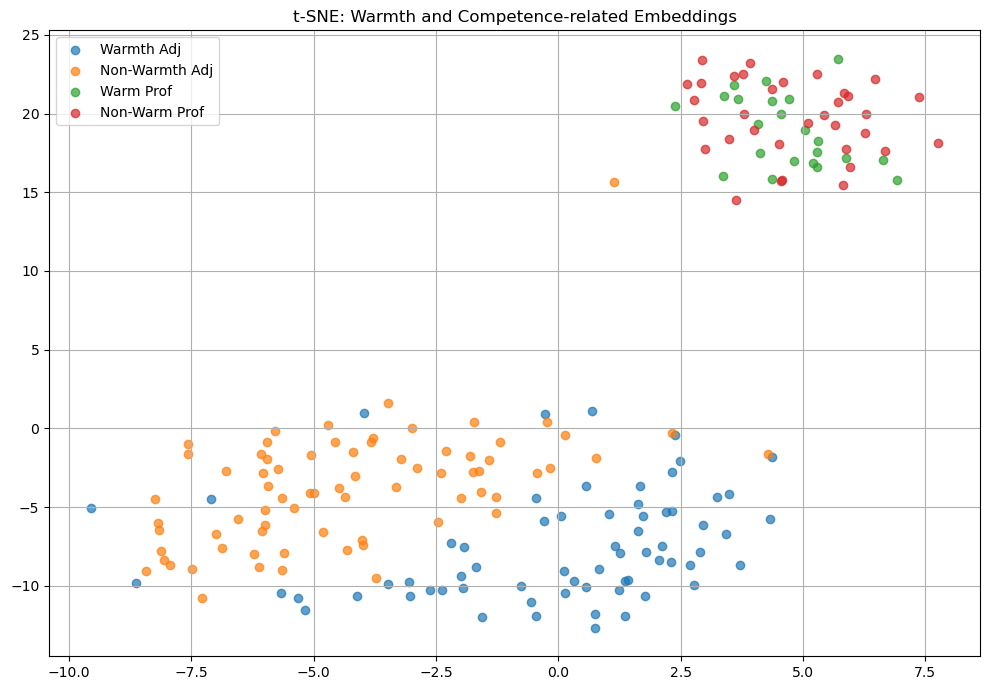

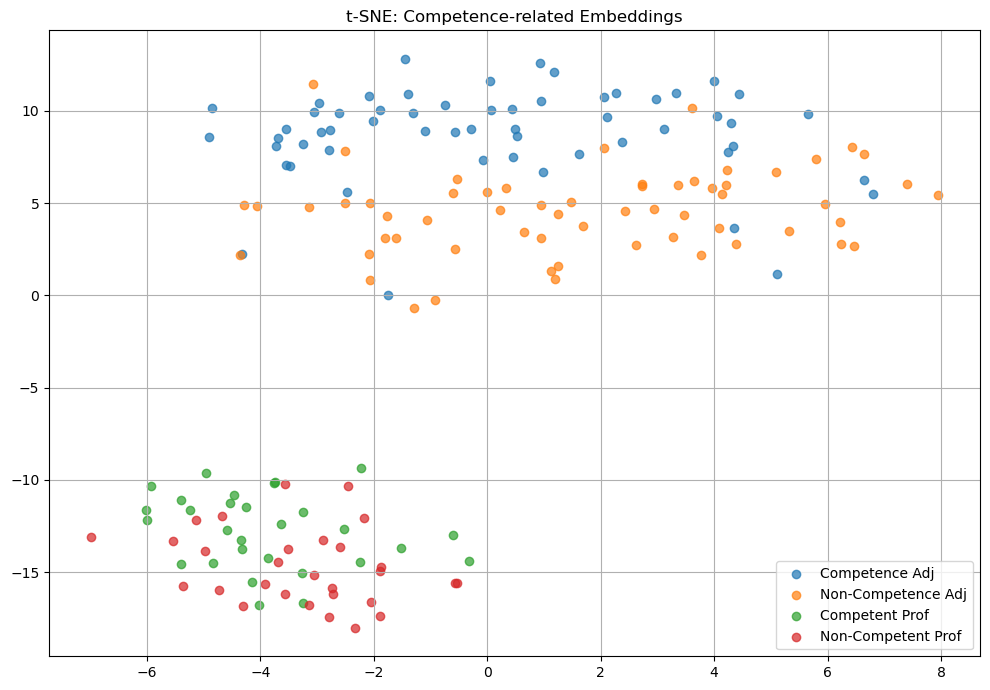

In [55]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_tsne(embeddings_dict, title="t-SNE Projection of Embeddings"):
    #flatten and prepare all embeddings
    all_embeddings = torch.cat(list(embeddings_dict.values()), dim=0).numpy()
    all_labels = sum([[label] * len(emb) for label, emb in embeddings_dict.items()], [])

    #t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(all_embeddings)

    #plot
    plt.figure(figsize=(10, 7))
    for label in embeddings_dict:
        idx = [i for i, l in enumerate(all_labels) if l == label]
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=label, alpha=0.7)

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

visualize_tsne({
    "Warmth Adj": warmth_emb,
    "Non-Warmth Adj": non_warmth_emb,
    "Warm Prof": prof_warm_emb,
    "Non-Warm Prof": prof_nonwarm_emb
}, title="t-SNE: Warmth and Competence-related Embeddings")

visualize_tsne({
    "Competence Adj": competence_emb,
    "Non-Competence Adj": non_competence_emb,
    "Competent Prof": prof_competence_emb,
    "Non-Competent Prof": prof_non_competence_emb
}, title="t-SNE: Competence-related Embeddings")


In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForMaskedLM

# Load custom bias directions
warmth_vector = pd.read_csv('/Users/aleksandragarbat/Desktop/Thesis/warmth_direction.csv').values.flatten()
competence_vector = pd.read_csv('/Users/aleksandragarbat/Desktop/Thesis/competence_direction.csv').values.flatten()

warmth_vector = torch.tensor(warmth_vector, dtype=torch.float32)
competence_vector = torch.tensor(competence_vector, dtype=torch.float32)

# Normalize bias direction vectors
warmth_vector = warmth_vector / warmth_vector.norm()
competence_vector = competence_vector / competence_vector.norm()

# Load model and tokenizer
model_path = "/Users/aleksandragarbat/Desktop/BERT_finetuned"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForMaskedLM.from_pretrained(model_path).eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_profession_embedding(profession):
    sentence = f"The {profession} is a person."
    inputs = tokenizer(sentence, return_tensors='pt').to(device)
    with torch.no_grad():
        outputs = model.bert(**inputs)
    emb = outputs.last_hidden_state.mean(dim=1).squeeze()  # [hidden_size]
    return emb.cpu()

def cosine_similarity(vec1, vec2):
    #both vectors are 1D tensors
    vec1 = vec1 / vec1.norm()
    vec2 = vec2 / vec2.norm()
    return torch.dot(vec1, vec2).item()

def cosine_similarity_scores(professions, direction_vector):
    direction_vector = direction_vector.to(device)
    cos_sims = {}
    for prof in professions:
        emb = get_profession_embedding(prof).to(device)
        sim = cosine_similarity(emb, direction_vector)
        cos_sims[prof] = sim
    return cos_sims

professions = [
    "professor", "vet", "paramedic", "chef", "dentist", "maid", "doctor", "nurse",
    "scientist", "welder", "teacher", "waiter", "mechanic", "police", "secretary",
    "psychiatrist", "farmer", "pilot", "director", "architect", "c.e.o", "artist",
    "writer", "fisherman", "medical assistant", "manager", "librarian", "politician",
    "engineer", "bartender", "accountant", "firefighter", "travel agent", "lawyer",
    "actor", "lab technician", "security guard", "custodian", "childcare worker",
    "bank teller", "taxi driver", "bus driver", "news anchor", "customer service representative",
    "cashier", "plumber", "technical support worker", "electrician", "graphic designer",
    "financial advisor", "salesperson", "truck driver", "landscaper", "postal worker",
    "factory worker", "garbage collector", "computer programmer", "construction worker"
]

# Calculate cosine similarity scores
warmth_cosine_scores = cosine_similarity_scores(professions, warmth_vector)
competence_cosine_scores = cosine_similarity_scores(professions, competence_vector)

print("\n--- Warmth Cosine Similarities ---")
for p, score in sorted(warmth_cosine_scores.items(), key=lambda x: -x[1]):
    print(f"{p:25} : {score:.4f}")

print("\n--- Competence Cosine Similarities ---")
for p, score in sorted(competence_cosine_scores.items(), key=lambda x: -x[1]):
    print(f"{p:25} : {score:.4f}")

import numpy as np



avg_warmth = np.mean(list(warmth_cosine_scores.values()))
avg_competence = np.mean(list(competence_cosine_scores.values()))

print(f"Average Warmth Cosine Similarity: {avg_warmth:.4f}")
print(f"Average Competence Cosine Similarity: {avg_competence:.4f}")


In [ ]:
#project back + projection plot
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForMaskedLM

#load custom bias directions
warmth_vector = pd.read_csv('/Users/aleksandragarbat/Desktop/Thesis/warmth_direction.csv').values.flatten()
competence_vector = pd.read_csv('/Users/aleksandragarbat/Desktop/Thesis/competence_direction.csv').values.flatten()

warmth_vector = torch.tensor(warmth_vector, dtype=torch.float32)
competence_vector = torch.tensor(competence_vector, dtype=torch.float32)

#normalize vectors
warmth_vector = warmth_vector / warmth_vector.norm()
competence_vector = competence_vector / competence_vector.norm()

#load model and tokenizer
model_path = "/Users/aleksandragarbat/Desktop/BERT_finetuned"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForMaskedLM.from_pretrained(model_path).eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_profession_embedding(profession):
    sentence = f"The {profession} is a person."
    inputs = tokenizer(sentence, return_tensors='pt').to(device)
    with torch.no_grad():
        outputs = model.bert(**inputs)
    #mean pooling over sequence length dimension
    emb = outputs.last_hidden_state.mean(dim=1).squeeze()  # [hidden_size]
    return emb.cpu()

def project_embeddings(professions, direction_vector):
    direction_vector = direction_vector.to(device)
    projections = {}
    for prof in professions:
        emb = get_profession_embedding(prof).to(device)
        score = torch.dot(emb, direction_vector).item()  # scalar projection
        projections[prof] = score
    return projections

#professions list
professions = [
    "professor", "vet", "paramedic", "chef", "dentist", "maid", "doctor", "nurse",
    "scientist", "welder", "teacher", "waiter", "mechanic", "police", "secretary",
    "psychiatrist", "farmer", "pilot", "director", "architect", "c.e.o", "artist",
    "writer", "fisherman", "medical assistant", "manager", "librarian", "politician",
    "engineer", "bartender", "accountant", "firefighter", "travel agent", "lawyer",
    "actor", "lab technician", "security guard", "custodian", "childcare worker",
    "bank teller", "taxi driver", "bus driver", "news anchor", "customer service representative",
    "cashier", "plumber", "technical support worker", "electrician", "graphic designer",
    "financial advisor", "salesperson", "truck driver", "landscaper", "postal worker",
    "factory worker", "garbage collector", "computer programmer", "construction worker"
]

#project onto custom bias directions
warmth_scores = project_embeddings(professions, warmth_vector)
competence_scores = project_embeddings(professions, competence_vector)

print("\n--- Warmth Projections ---")
for p, score in sorted(warmth_scores.items(), key=lambda x: -x[1]):
    print(f"{p}: {score:.4f}")

print("\n--- Competence Projections ---")
for p, score in sorted(competence_scores.items(), key=lambda x: -x[1]):
    print(f"{p}: {score:.4f}")
####plot for projections
import matplotlib.pyplot as plt

# Prepare coordinates
x_vals = [warmth_scores[prof] for prof in professions]
y_vals = [competence_scores[prof] for prof in professions]

plt.figure(figsize=(12, 8))
plt.scatter(x_vals, y_vals)

# Add profession labels
for i, prof in enumerate(professions):
    plt.text(x_vals[i] + 0.002, y_vals[i] + 0.002, prof, fontsize=9)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)
plt.title("Profession Projections on Warmth and Competence Bias Directions")
plt.xlabel("Warmth Score")
plt.ylabel("Competence Score")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
#embeddings extraction

from transformers import BertTokenizer, BertForMaskedLM
import torch
import csv

#load model and tokenizer
model_path = "/Users/aleksandragarbat/Desktop/BERT_finetuned"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = DebiasedBertForMaskedLM.from_pretrained(model_path, components=components, weights=weights, tokenizer=tokenizer)
model.to(device)
model.eval()

def get_profession_embedding(profession, model, tokenizer, device):
    sentence = f"The {profession} is there."  # neutral context
    inputs = tokenizer(sentence, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.bert(**inputs, return_dict=True)
        hidden_states = outputs.last_hidden_state.squeeze(0)  # shape: [seq_len, hidden_dim]

    tokens = tokenizer.tokenize(sentence)
    profession_tokens = tokenizer.tokenize(profession)

    #find start index of profession tokens
    for i in range(len(tokens) - len(profession_tokens) + 1):
        if tokens[i:i+len(profession_tokens)] == profession_tokens:
            start, end = i, i + len(profession_tokens)
            break
    else:
        raise ValueError(f"Could not find token span for profession: {profession}")

    #get mean embedding over profession token span
    profession_embedding = hidden_states[start+1:end+1].mean(dim=0)  # +1 due to [CLS] token at position 0
    return profession_embedding.cpu()

import pandas as pd

professions = [
    "professor", "vet", "paramedic", "chef", "dentist", "maid", "doctor", "nurse",
    "scientist", "welder", "teacher", "waiter", "mechanic", "police", "secretary",
    "psychiatrist", "farmer", "pilot", "director", "architect", "c.e.o", "artist",
    "writer", "fisherman", "medical assistant", "manager", "librarian", "politician",
    "engineer", "bartender", "accountant", "firefighter", "travel agent", "lawyer",
    "actor", "lab technician", "security guard", "custodian", "childcare worker",
    "bank teller", "taxi driver", "bus driver", "news anchor", "customer service representative",
    "cashier", "plumber", "technical support worker", "electrician", "graphic designer",
    "financial advisor", "salesperson", "truck driver", "landscaper", "postal worker",
    "factory worker", "garbage collector", "computer programmer", "construction worker"
]

embedding_dict = {}
for prof in tqdm(professions):
    try:
        emb = get_profession_embedding(prof, model, tokenizer, device)
        embedding_dict[prof] = emb.numpy()
    except Exception as e:
        print(f"Could not extract embedding for {prof}: {e}")

#save to csv
csv_path = "profession_embeddings_debiased_w=0.5_c=0.5.csv"
with open(csv_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    
    #determine the dimension from one of the embeddings
    dim = next(iter(embedding_dict.values())).shape[0]
    
    #header: ["Profession", "dim_0", "dim_1", ..., "dim_n"]
    header = ["Profession"] + [f"dim_{i}" for i in range(dim)]
    writer.writerow(header)
    
    # Write each profession and its embedding
    for prof, emb in embedding_dict.items():
        row = [prof] + emb.tolist()
        writer.writerow(row)

print(f"Saved profession embeddings to {csv_path}")

